# Pedestal Estimation from GSFC Calibration Images

In [1]:
import pathlib
import astropy.units as u
import astropy.io.fits
import xarray
import matplotlib.pyplot as plt
import numpy as np
import dask.array
import pandas
import tqdm
import distributed

from astropy.visualization import ImageNormalize, AsymmetricPercentileInterval

In [2]:
data_dir = pathlib.Path('../data/moxsi_gsfc_calibration_images/')

In [3]:
all_fits_files = sorted(data_dir.glob('csie_image_*.bin.fits'))
# Skip the first file due to uncertainty in the true exposure time
all_fits_files = all_fits_files[1:]

In [4]:
len(all_fits_files)

4598

In [ ]:
# scale=True is for "det0", which is the detector temperature
def steinharthart(coeff, scale=False):
    def func(dn):
        r = dn / (4096 - dn)
        if scale:
            r *= 10000
        result = 1 / np.poly1d(coeff[::-1])(np.log(r)) - 273.15
        return result
    return func

In [ ]:
# These are the Steinhart-Hart functions, which we will use
det0temp_sh = steinharthart([1.1292E-03, 2.3411E-04, 0.0000E+00, 8.7755E-08], scale=True)
det1temp_sh = steinharthart([3.3540E-03, 2.5708E-04, 1.8939E-06, 1.8973E-07])
fpgatemp_sh = steinharthart([3.3540E-03, 2.5708E-04, 1.8939E-06, 1.8973E-07])
thermadc_sh = steinharthart([3.3540E-03, 3.0013E-04, 5.0852E-06, 2.1877E-07])

In [ ]:
client = distributed.Client()

In [ ]:
client

In [ ]:
data = np.empty((len(all_fits_files),2000,1504))
temp_det_1 = []
temp_det_0 = []
temp_adc = []
exposure_time = []
time = []
meta_keys = [
    'DET0TEMP', 'DET1TEMP', 'THERMADC', 'FPGATEMP', 'EXPTIME', 'DATE', 'FRAME_ID'
]
meta_arrays = {k: [] for k in meta_keys}
for i,filename in enumerate(tqdm.tqdm(all_fits_files)):
    with astropy.io.fits.open(filename, memmap=False) as hdul:
        _header = hdul[0].header
        data[i,...] = hdul[0].data[:2000,:]  #disregard extra row
    for k in meta_arrays.keys():
        meta_arrays[k].append(_header[k])
time_coord = pandas.to_datetime(meta_arrays['DATE'])
data = dask.array.from_array(data,
                             chunks=(None, data.shape[1]//20, data.shape[2]//20))
ds = xarray.Dataset(
    {
        'data': (["sample", "row", "column"], data),
    #    'temperature_detector_0': (["sample"], np.array(meta_arrays['DET0TEMP'])),
    #    'temperature_detector_1': (["sample"], np.array(meta_arrays['DET1TEMP'])),
    #    'temperature_adc': (["sample"], np.array(meta_arrays['THERMADC'])),
    #    'temperature_fpga': (["sample"], np.array(meta_arrays['FPGATEMP'])),
    #    'exposure_time': (["sample"], np.array(meta_arrays['EXPTIME'])),
    },
    coords={
        "time": (["sample"], time_coord),
        "frame_id": (["sample"], np.array(meta_arrays['FRAME_ID'])),
        'temperature_detector_0': (["sample"], np.array(meta_arrays['DET0TEMP'])),
        'temperature_detector_1': (["sample"], np.array(meta_arrays['DET1TEMP'])),
        'temperature_adc': (["sample"], np.array(meta_arrays['THERMADC'])),
        'temperature_fpga': (["sample"], np.array(meta_arrays['FPGATEMP'])),
        'exposure_time': (["sample"], np.array(meta_arrays['EXPTIME'])),
    }
)
# Apply conversion functions for temperature
ds['temperature_detector_0'].data = det0temp_sh(ds['temperature_detector_0'])
ds['temperature_detector_1'].data = det1temp_sh(ds['temperature_detector_1'])
ds['temperature_adc'].data = thermadc_sh(ds['temperature_adc'])
ds['temperature_fpga'].data = fpgatemp_sh(ds['temperature_fpga'])
# Correct exposure time
exptime_fixed = np.empty_like(ds['exposure_time'].data)
exptime_fixed[:414] = np.where(ds['exposure_time'].data[:414] == 1250, 5000, 1250)
exptime_fixed[414:] = np.where(
    ds['exposure_time'].data[414:] == 2500,
    1250,
    np.where(ds['exposure_time'].data[414:] == 5000, 2500, 5000)
)
exptime_fixed[614] = 5000  # this single image needs to be separately fixed
ds['exposure_time'].data = exptime_fixed
# Add unit information
ds['data'].attrs['unit'] = 'DN'
for k in ['detector_0', 'detector_1', 'adc', 'fpga']:
    ds[f'temperature_{k}'].attrs['unit'] = 'deg C'
ds['exposure_time'].attrs['unit'] = 'ms'

In [43]:
ds['data'].column.size//10

150

In [ ]:
ds.to_zarr(data_dir / 'images.zarr')

Or alternatively, just load it from the Zarr file we wrote.

In [3]:
ds = xarray.open_zarr(data_dir / 'images.zarr')

In [ ]:
ds.rech

In [44]:
ds['data']

<xarray.DataArray 'data' (sample: 4598, row: 2000, column: 1504)> Size: 111GB
dask.array<open_dataset-data, shape=(4598, 2000, 1504), dtype=float64, chunksize=(4598, 100, 75), chunktype=numpy.ndarray>
Coordinates:
    exposure_time           (sample) int64 37kB dask.array<chunksize=(4598,), meta=np.ndarray>
    frame_id                (sample) int64 37kB dask.array<chunksize=(4598,), meta=np.ndarray>
    temperature_adc         (sample) float64 37kB dask.array<chunksize=(4598,), meta=np.ndarray>
    temperature_detector_0  (sample) float64 37kB dask.array<chunksize=(4598,), meta=np.ndarray>
    temperature_detector_1  (sample) float64 37kB dask.array<chunksize=(4598,), meta=np.ndarray>
    temperature_fpga        (sample) float64 37kB dask.array<chunksize=(4598,), meta=np.ndarray>
    time                    (sample) datetime64[ns] 37kB dask.array<chunksize=(4598,), meta=np.ndarray>
Dimensions without coordinates: sample, row, column
Attributes:
    unit:     DN

In [ ]:
ds['data']

In [53]:
foo = ds['data'].chunk({'sample': ds['data'].sample.size,
                        'row': 200,#ds['data'].row.size//10,
                        'column':200,})#ds['data'].column.size//10})

In [54]:
foo

<xarray.DataArray 'data' (sample: 4598, row: 2000, column: 1504)> Size: 111GB
dask.array<rechunk-merge, shape=(4598, 2000, 1504), dtype=float64, chunksize=(4598, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    exposure_time           (sample) int64 37kB dask.array<chunksize=(4598,), meta=np.ndarray>
    frame_id                (sample) int64 37kB dask.array<chunksize=(4598,), meta=np.ndarray>
    temperature_adc         (sample) float64 37kB dask.array<chunksize=(4598,), meta=np.ndarray>
    temperature_detector_0  (sample) float64 37kB dask.array<chunksize=(4598,), meta=np.ndarray>
    temperature_detector_1  (sample) float64 37kB dask.array<chunksize=(4598,), meta=np.ndarray>
    temperature_fpga        (sample) float64 37kB dask.array<chunksize=(4598,), meta=np.ndarray>
    time                    (sample) datetime64[ns] 37kB dask.array<chunksize=(4598,), meta=np.ndarray>
Dimensions without coordinates: sample, row, column
Attributes:
    unit:     DN

Make a few plots to verify I've loaded the data correctly.

In [ ]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot()
ax.grid()
ds['temperature_detector_0'].plot(x='frame_id',ls='',marker='.', markersize=1)
ds['temperature_detector_1'].plot(x='frame_id',ls='',marker='.', markersize=1)
ds['temperature_adc'].plot(x='frame_id',ls='',marker='.',markersize=1)
ds['temperature_fpga'].plot(x='frame_id',ls='',marker='.',markersize=1)

In [ ]:
median = ds['data'].median(dim=['row','column']).compute()

In [ ]:
median

In [ ]:
exp_time = ds.exposure_time.compute()
median[exp_time==1250].plot(marker='.',ls='',x='frame_id',markersize=1)
median[exp_time==2500].plot(marker='.',ls='',x='frame_id',markersize=1)
median[exp_time==5000].plot(marker='.',ls='',x='frame_id',markersize=1)

Now, try applying Albert's fitting function to each pixel

In [ ]:
def fitting_function(X, a, b, c, d, e, f):
    t_det0, t_adc, exposure = X
    return a + b * exposure * np.exp(t_det0 / c) + d * t_det0 + e * t_det0**2 + f * t_adc

In [ ]:
ds['data'][:,:10,:]

In [ ]:
ds_fit = ds['data'][:,:10,:].curvefit(
    #('temperature_detector_0', 'temperature_adc', 'exposure_time'),
    (ds.temperature_detector_0, ds.temperature_adc, ds.exposure_time),
    fitting_function,
    reduce_dims=['sample'],
)

In [ ]:
ds_fit

In [ ]:
da_coeffs = ds_fit.curvefit_coefficients.compute()

Or load fit coefficients from Markdown file

In [4]:
da_coeffs = xarray.open_dataarray(data_dir / 'fit_coefficients.nc')

In [5]:
da_coeffs

<xarray.DataArray 'curvefit_coefficients' (row: 2000, column: 1504, param: 6)> Size: 144MB
[18048000 values with dtype=float64]
Coordinates:
  * param    (param) <U1 24B 'a' 'b' 'c' 'd' 'e' 'f'
Dimensions without coordinates: row, column
Attributes:
    unit:     DN

$y = a + b t_{exp} \exp{T_{det0} / c} + d T_{det0} + e T_{det0}^2 + f T_{ADC}$

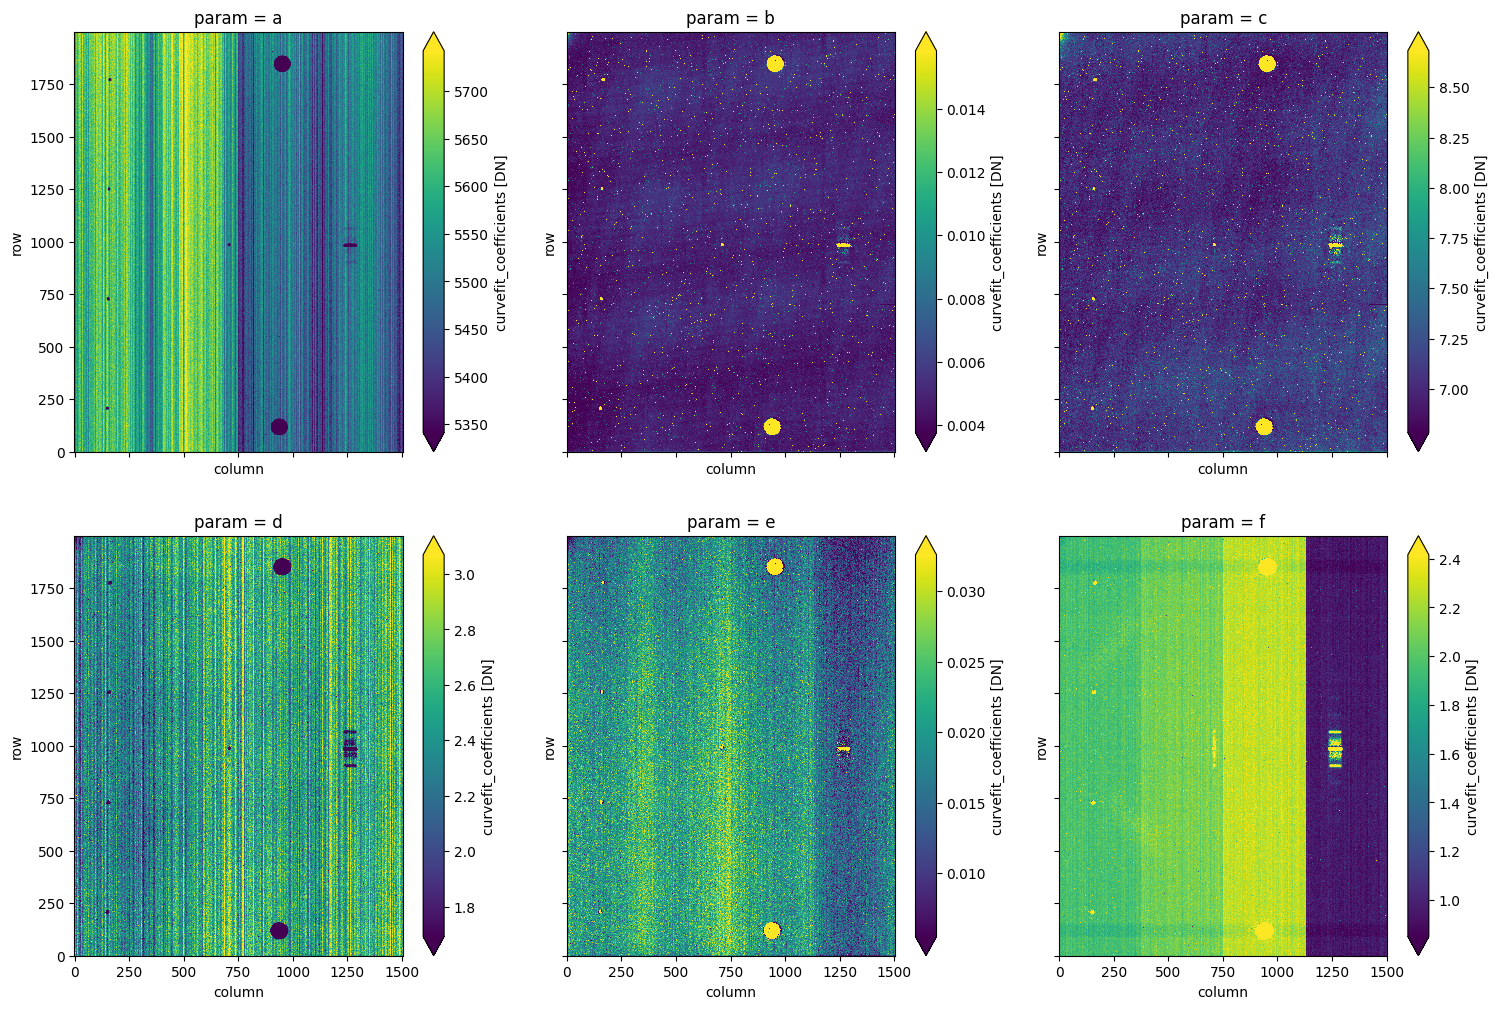

In [22]:
size = 6 
fig,axes = plt.subplots(2,3,figsize=(size*3,size*2),sharex=True,sharey=True)
for i,ax in enumerate(axes.flatten()):
    vmin, vmax = AsymmetricPercentileInterval(1,99).get_limits(da_coeffs[...,i].data)
    da_coeffs[...,i].plot.imshow(ax=ax, vmin=max(0,vmin), vmax=vmax)

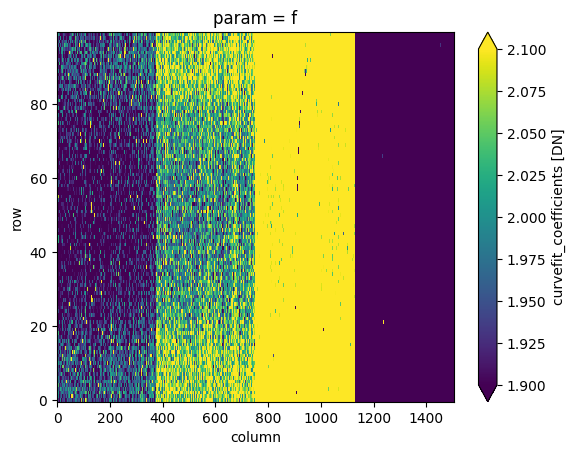

In [30]:
da_coeffs[-200:-100,:,-1].plot(vmin=1.9,vmax=2.1)

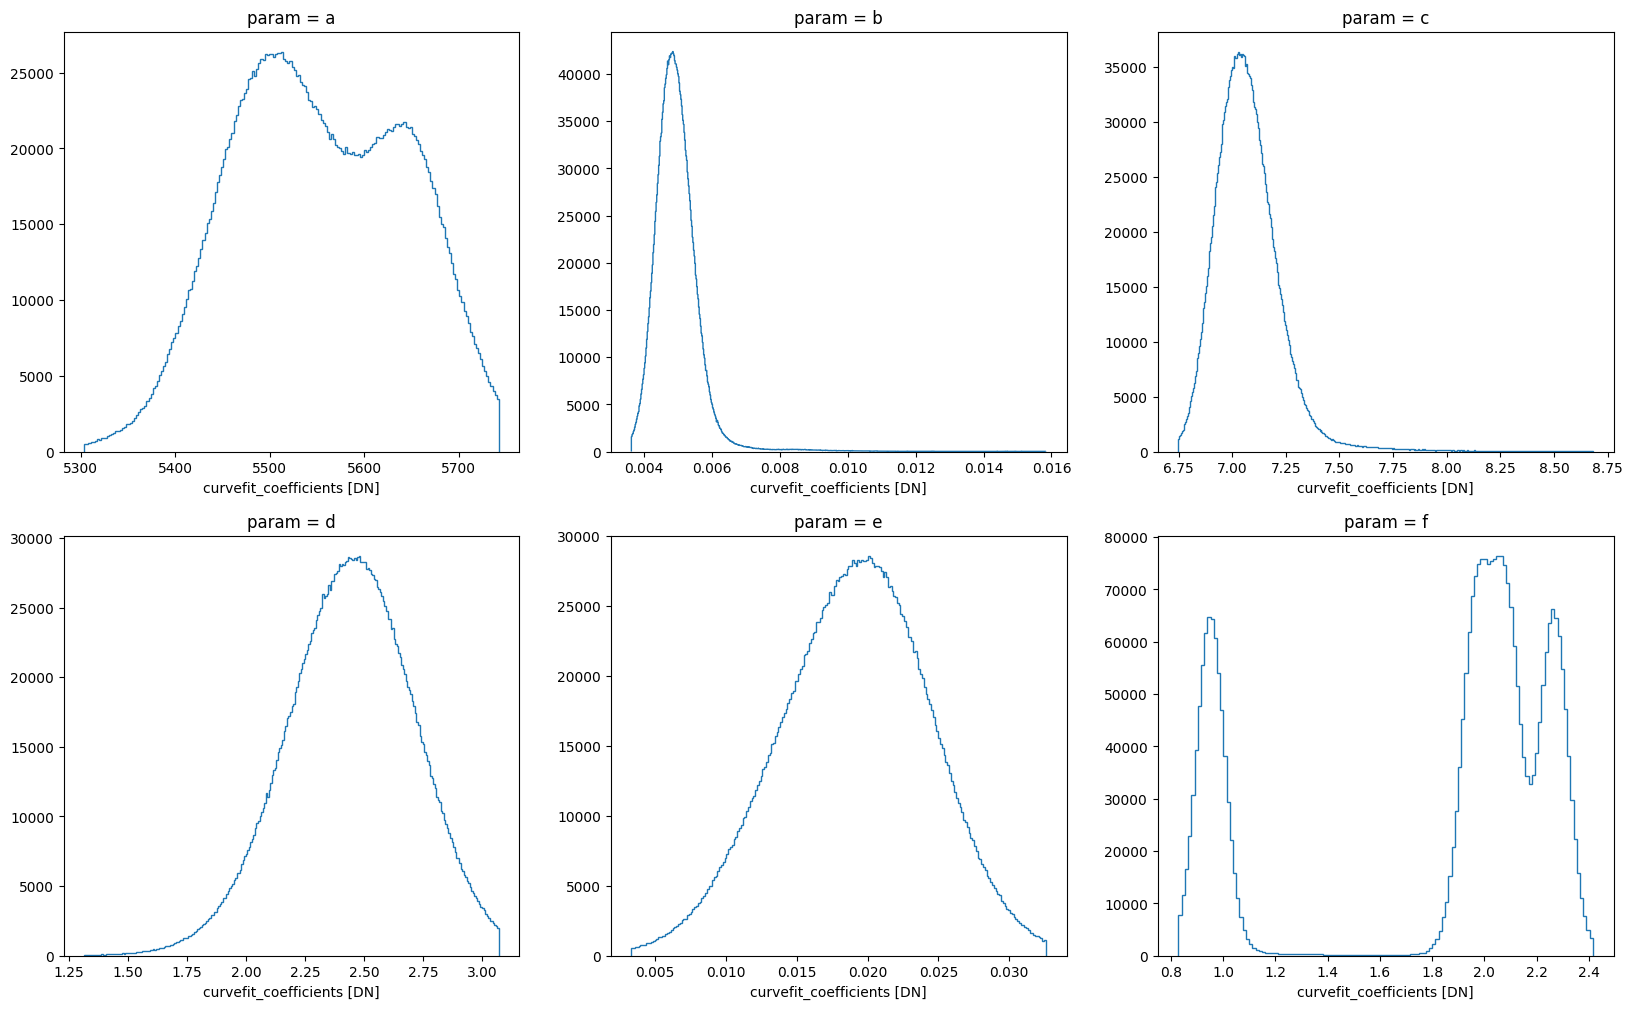

In [24]:
fig,axes = plt.subplots(2,3,figsize=(20,12),sharex=False,sharey=False)
for i,ax in enumerate(axes.flatten()):
    vmin, vmax = AsymmetricPercentileInterval(0.5,99).get_limits(da_coeffs[...,i].data)
    da_coeffs[...,i].plot.hist(ax=ax, bins='scott', range=(vmin,vmax), histtype='step', log=False);

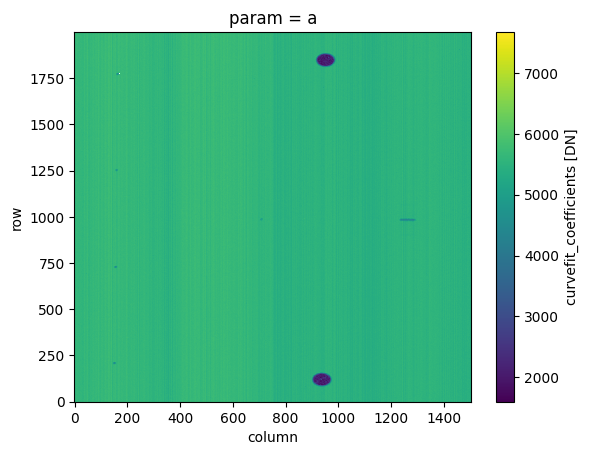

In [4]:
da_coeffs[...,0].plot()

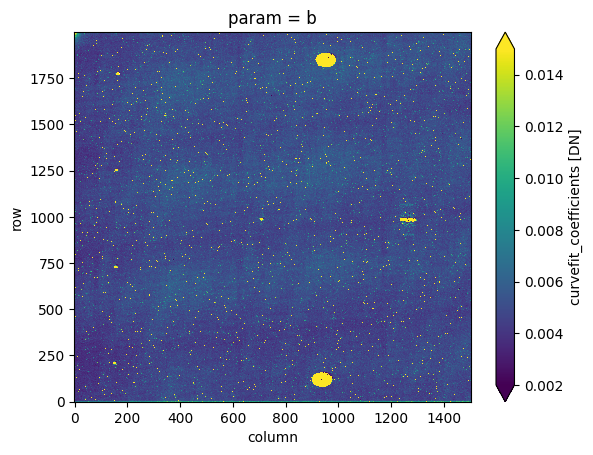

In [5]:
da_coeffs[...,1].plot(vmin=0.002,vmax=0.015)

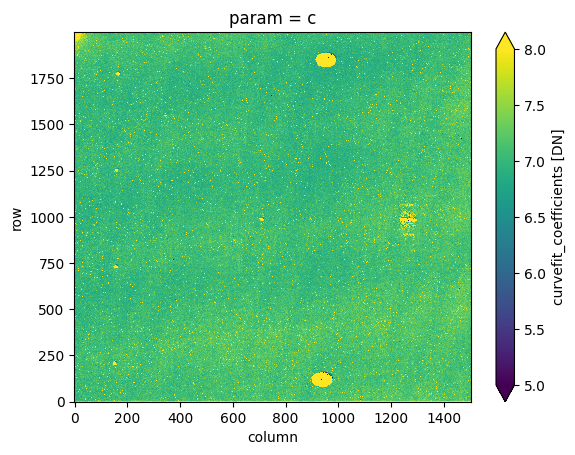

In [6]:
da_coeffs[...,2].plot(vmin=5, vmax=8)

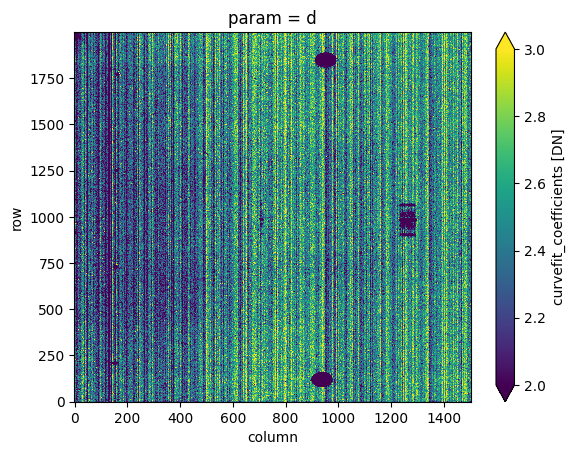

In [7]:
da_coeffs[...,3].plot(vmin=2,vmax=3)

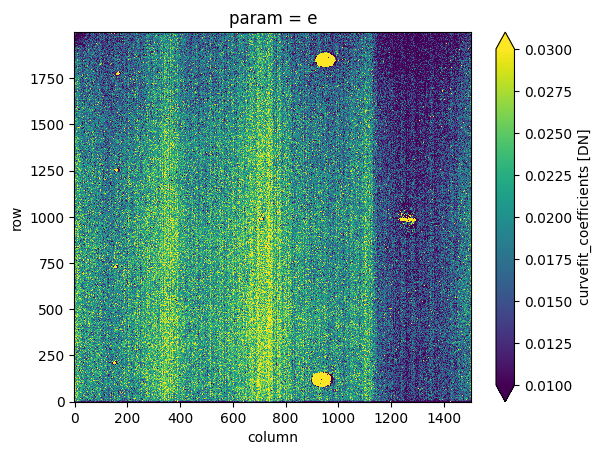

In [8]:
da_coeffs[...,4].plot(vmin=0.01, vmax=0.03)

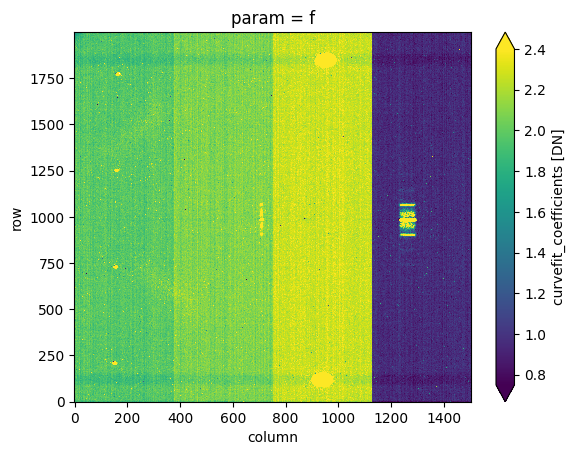

In [9]:
da_coeffs[...,5].plot(vmin=0.75,vmax=2.4)